# Descompactando o zip

In [3]:
import zipfile
import os

# Descompactar o arquivo zip
with zipfile.ZipFile("northwind.zip", "r") as zip:
    zip.extractall()

# Importando as tabelas

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar as tabelas
categories = pd.read_csv("categories.csv", sep=";")
customer_customer_demo = pd.read_csv("customer_customer_demo.csv", sep=";")
customer_demographics = pd.read_csv("customer_demographics.csv", sep=";")
customers = pd.read_csv("customers.csv", sep=";")
employees = pd.read_csv("employees.csv", sep=";")
employee_territories = pd.read_csv("employee_territories.csv", sep=";")
order_details = pd.read_csv("order_details.csv", sep=";")
orders = pd.read_csv("orders.csv", sep=";")
products = pd.read_csv("products.csv", sep=";")
region = pd.read_csv("region.csv", sep=";")
shippers = pd.read_csv("shippers.csv", sep=";")
suppliers = pd.read_csv("suppliers.csv", sep=";")
territories = pd.read_csv("territories.csv", sep=";")
us_states = pd.read_csv("us_states.csv", sep=";")

Dando uma olhada nas tabelas identifiquei alguns valores nulos

# Preenchendo dados faltantes

In [8]:
# Preencher dados faltantes no employees.csv
employees["region"].fillna("Unknown", inplace=True)
employees["reports_to"].fillna(0, inplace=True)

# Preencher dados faltantes no orders.csv
orders["shipped_date"].fillna(orders["order_date"], inplace=True)
orders["ship_region"].fillna("Unknown", inplace=True)
orders["ship_postal_code"].fillna("Unknown", inplace=True)

# Preencher dados faltantes no suppliers.csv
suppliers["region"].fillna("Unknown", inplace=True)
suppliers["fax"].fillna("None", inplace=True)
suppliers["homepage"].fillna("None", inplace=True)


# Desenvolvimento dos Indicadores de Performance

## Faturamento Total e por Categoria de Produto

### Total

In [12]:
# Calcular faturamento total
order_details["total"] = order_details["unit_price"] * order_details["quantity"] * (1 - order_details["discount"])
faturamento_total = order_details["total"].sum()

faturamento_total


1265793.0395

### Por categoria

In [14]:
# Mesclar order_details com products para obter a categoria
order_details_products = pd.merge(order_details, products, on="product_id")

# Calcular faturamento por categoria
faturamento_por_categoria = order_details_products.groupby("category_id")["total"].sum().reset_index()

faturamento_por_categoria

,category_id,total
0,1,267868.1800
1,2,106047.0850
2,3,167357.2250
3,4,234507.2850
4,5,95744.5875
5,6,163022.3595
6,7,99984.5800
7,8,131261.7375


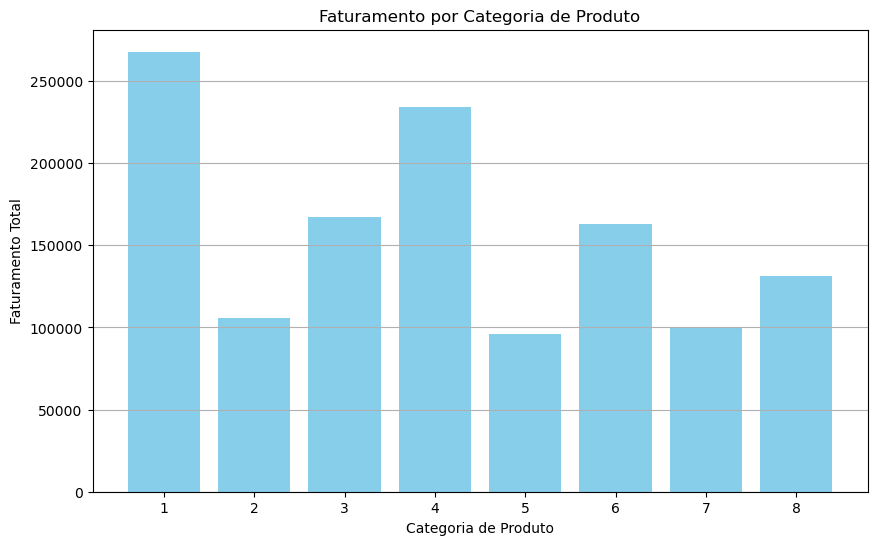

In [15]:
# Gráfico de barras para faturamento por categoria de produto
plt.figure(figsize=(10, 6))
plt.bar(faturamento_por_categoria["category_id"], faturamento_por_categoria["total"], color="skyblue")
plt.xlabel("Categoria de Produto")
plt.ylabel("Faturamento Total")
plt.title("Faturamento por Categoria de Produto")
plt.xticks(faturamento_por_categoria["category_id"])
plt.grid(axis="y")
plt.show()

## Ticket Médio

In [17]:
# Calcular o número total de pedidos
num_pedidos = orders["order_id"].nunique()

# Calcular o ticket médio
ticket_medio = faturamento_total / num_pedidos
ticket_medio


1525.051854819277

## Churn Rate

In [19]:
# Converter datas para datetime
orders["order_date"] = pd.to_datetime(orders["order_date"])
orders["year"] = orders["order_date"].dt.year

# Considerar o último ano com dados
ultimo_ano = orders["year"].max()

# Clientes ativos no último ano
clientes_ativos_ultimo_ano = orders[orders["year"] == ultimo_ano]["customer_id"].unique()

# Clientes ativos no penúltimo ano
clientes_ativos_penultimo_ano = orders[orders["year"] == (ultimo_ano - 1)]["customer_id"].unique()

# Clientes que deixaram de fazer pedidos (churn)
clientes_churn = set(clientes_ativos_penultimo_ano) - set(clientes_ativos_ultimo_ano)

# Calcular churn rate
churn_rate = len(clientes_churn) / len(clientes_ativos_penultimo_ano)
churn_rate


0.08139534883720931

## Tempo Médio de Entrega

In [21]:
# Calcular tempo de entrega
orders["tempo_entrega"] = (pd.to_datetime(orders["shipped_date"]) - pd.to_datetime(orders["order_date"])).dt.days

# Calcular tempo médio de entrega
tempo_medio_entrega = orders["tempo_entrega"].mean()
tempo_medio_entrega


8.27710843373494

## Análise Geográfica das Vendas

In [23]:
# Mesclar orders com customers para obter informações geográficas
orders_customers = pd.merge(orders, customers, on="customer_id")

# Calcular faturamento por país
faturamento_por_pais = orders_customers.merge(order_details, on="order_id").groupby("country")["total"].sum().reset_index()
faturamento_por_pais


,country,total
0,Argentina,8119.1000
1,Austria,128003.8385
2,Belgium,33824.8550
3,Brazil,106925.7765
4,Canada,50196.2900
5,Denmark,32661.0225
6,Finland,18810.0525
7,France,81358.3225
8,Germany,230284.6335
9,Ireland,49979.9050


## Top Clientes e Fornecedores

### Clientes

In [26]:
# Calcular faturamento por cliente
faturamento_por_cliente = orders.merge(order_details, on="order_id").groupby("customer_id")["total"].sum().reset_index()

# Identificar top 5 clientes
top_clientes = faturamento_por_cliente.sort_values(by="total", ascending=False).head(5)
top_clientes


,customer_id,total
60,QUICK,110277.3050
19,ERNSH,104874.9785
68,SAVEA,104361.9500
62,RATTC,51097.8005
35,HUNGO,49979.9050


### Fornecedores

In [28]:
# Mesclar order_details com products para obter o fornecedor
order_details_products_suppliers = pd.merge(order_details_products, suppliers, on="supplier_id")

# Calcular faturamento por fornecedor
faturamento_por_fornecedor = order_details_products_suppliers.groupby("supplier_id")["total"].sum().reset_index()

# Identificar top 5 fornecedores
top_fornecedores = faturamento_por_fornecedor.sort_values(by="total", ascending=False).head(5)
top_fornecedores


,supplier_id,total
17,18,153691.2750
11,12,145372.3995
27,28,117981.1800
6,7,106459.7755
23,24,65626.7700


## Performance dos Produtos

In [30]:
# Calcular unidades vendidas por produto
unidades_vendidas_por_produto = order_details.groupby("product_id")["quantity"].sum().reset_index()

# Calcular faturamento por produto
faturamento_por_produto = order_details.groupby("product_id")["total"].sum().reset_index()

# Mesclar dados de produtos para obter informações detalhadas
performance_produtos = pd.merge(unidades_vendidas_por_produto, faturamento_por_produto, on="product_id")
performance_produtos = pd.merge(performance_produtos, products, on="product_id")
performance_produtos


,product_id,quantity,total,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,828,12788.10,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
1,2,1057,16355.96,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,1
2,3,328,3044.00,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,453,8567.90,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,298,5347.20,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
72,73,293,3997.20,Röd Kaviar,17,8,24 - 150 g jars,15.00,101,0,5,0
73,74,297,2432.50,Longlife Tofu,4,7,5 kg pkg.,10.00,4,20,5,0
74,75,1155,8177.49,Rhönbräu Klosterbier,12,1,24 - 0.5 l bottles,7.75,125,0,25,0
75,76,981,15760.44,Lakkalikööri,23,1,500 ml,18.00,57,0,20,0


## Distribuição de Pedidos por Ano e Mês

In [32]:
# Extrair ano e mês
orders["ano"] = orders["order_date"].dt.year
orders["mes"] = orders["order_date"].dt.month

# Contar pedidos por ano e mês
pedidos_por_ano_mes = orders.groupby(["ano", "mes"])["order_id"].count().reset_index()

# Pivotar tabela para melhor visualização
pedidos_por_ano_mes_pivot = pedidos_por_ano_mes.pivot(index="ano", columns="mes", values="order_id").fillna(0)
pedidos_por_ano_mes_pivot

mes,1,2,3,4,5,6,7,8,9,10,11,12
ano,,,,,,,,,,,,
1996,0.0,0.0,0.0,0.0,0.0,0.0,22.0,25.0,23.0,26.0,25.0,31.0
1997,33.0,29.0,30.0,31.0,32.0,30.0,33.0,33.0,37.0,38.0,34.0,48.0
1998,55.0,54.0,73.0,74.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


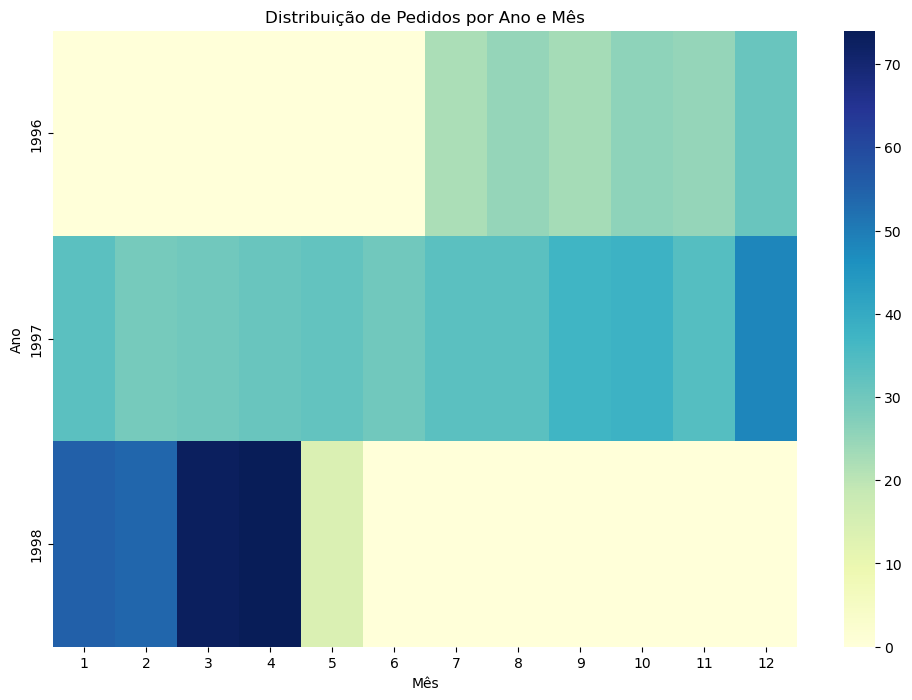

In [33]:
# Gráfico de calor para distribuição de pedidos por ano e mês
plt.figure(figsize=(12, 8))
plt.title("Distribuição de Pedidos por Ano e Mês")
sns.heatmap(pedidos_por_ano_mes_pivot, fmt="g", cmap="YlGnBu")
plt.xlabel("Mês")
plt.ylabel("Ano")
plt.show()


## Análise de Recência, Frequência e Valor Monetário (RFM)

In [35]:
import datetime as dt

# Data de referência para cálculo de recência
data_referencia = orders["order_date"].max() + dt.timedelta(days=1)

# Calcular Recência
recencia = orders.groupby("customer_id")["order_date"].max().reset_index()
recencia["recencia"] = (data_referencia - recencia["order_date"]).dt.days

# Calcular Frequência
frequencia = orders.groupby("customer_id")["order_id"].count().reset_index()
frequencia.columns = ["customer_id", "frequencia"]

# Calcular Valor Monetário
valor_monetario = orders.merge(order_details, on="order_id").groupby("customer_id")["total"].sum().reset_index()

# Mesclar RFM
rfm = recencia.merge(frequencia, on="customer_id").merge(valor_monetario, on="customer_id")

# Níveis de R, F e M - 5 níveis
niveis_r = range(5, 0, -1)
niveis_f = range(1, 6)
niveis_m = range(1, 6)

# Dividir a lista de clientes em 5 quintis
r_quintis = pd.qcut(rfm["recencia"], q=5, labels=niveis_r)
f_quintis = pd.qcut(rfm["frequencia"], q=5, labels=niveis_f)
m_quintis = pd.qcut(rfm["total"], q=5, labels=niveis_m)

# Atribuir níveis RFM
rfm = rfm.assign(R=r_quintis, F=f_quintis, M=m_quintis)

# Converter para int para cálculos
rfm["R"] = rfm["R"].astype("int64")
rfm["F"] = rfm["F"].astype("int64")
rfm["M"] = rfm["M"].astype("int64")

# Criar tabela com níveis RFM e pontuação RFM
def add_rfm(x):
    return str(x["R"]) + str(x["F"]) + str(x["M"])

rfm["RFM_cluster"] = rfm.apply(add_rfm, axis=1)
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm["FM_media"] = rfm[["F", "M"]].mean(axis=1).round()
rfm = rfm.reset_index()

rfm["R"] = rfm["R"].astype("int64")
rfm["FM_media"] = rfm["FM_media"].astype("int64")

# Classificar Clientes
def classificar(df):
    if (df["FM_media"] == 5) and (df["R"] == 1):
        return "Não posso perdê-lo"
    elif (df["FM_media"] == 5) and ((df["R"] == 3) or (df["R"] == 4)):
        return "Cliente leal"
    elif (df["FM_media"] == 5) and (df["R"] == 5):
        return "Campeão"
    elif (df["FM_media"] == 4) and (df["R"] >= 3):
        return "Cliente leal"    
    elif (df["FM_media"] == 3) and (df["R"] == 3):
        return "Precisa de atenção"    
    elif ((df["FM_media"] == 3) or (df["FM_media"] == 2)) and (df["R"] > 3):
        return "Lealdade potencial" 
    elif ((df["FM_media"] == 2) or (df["FM_media"] == 1)) and (df["R"] == 1):
        return "Perdido"     
    elif (df["FM_media"] == 2) and (df["R"] == 2):
        return "Hibernando"     
    elif ((df["FM_media"] == 2) or (df["FM_media"] == 1)) and (df["R"] == 3):
        return "Prestes a hibernar"
    elif (df["FM_media"] == 1) and (df["R"] == 2):
        return "Perdido"
    elif (df["FM_media"] == 1) and (df["R"] == 4):
        return "Promissor"       
    elif (df["FM_media"] == 1) and (df["R"] == 5):
        return "Recentes"  
    else:
        return "Em risco"

rfm["Classe"] = rfm.apply(classificar, axis=1)

# Exibir resultado
rfm.head()



,index,customer_id,order_date,recencia,frequencia,total,R,F,M,RFM_cluster,RFM_score,FM_media,Classe
0,0,ALFKI,1998-04-09,28,6,4273.0000,3,2,2,322,7,2,Prestes a hibernar
1,1,ANATR,1998-03-04,64,4,1402.9500,2,1,1,211,4,1,Perdido
2,2,ANTON,1998-01-28,99,7,7023.9775,1,2,3,123,6,2,Perdido
3,3,AROUT,1998-04-10,27,13,13390.6500,3,4,4,344,11,4,Cliente leal
4,4,BERGS,1998-03-04,64,18,24927.5775,2,5,5,255,12,5,Em risco


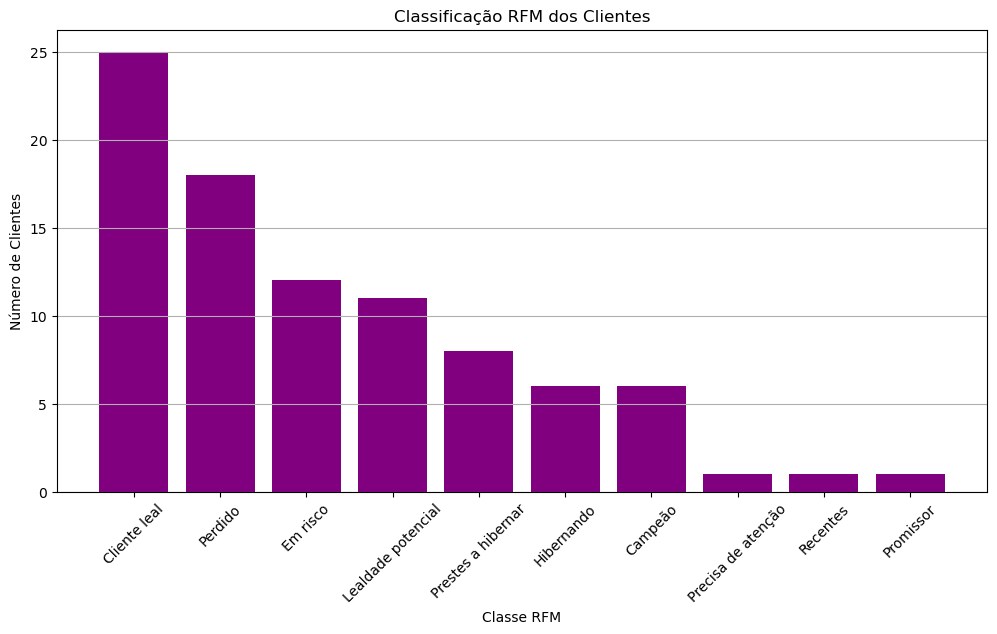

In [36]:
# Gráfico de barras para classificação RFM
plt.figure(figsize=(12, 6))
rfm_classificacao = rfm["Classe"].value_counts()
plt.bar(rfm_classificacao.index, rfm_classificacao.values, color="purple")
plt.xlabel("Classe RFM")
plt.ylabel("Número de Clientes")
plt.title("Classificação RFM dos Clientes")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()